In [1]:
import sys
sys.path.append("../../")
from simulation_classes.drones import Drones
from simulation_classes.simulation_setting import SimulationSettings
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

#### シミュレーターの設定(スケーリング含む)に必要な各種パラメータ
- 時間系
  - TOTAL_TIME: シミュレートする秒数
  - delta_t: 時間間隔
  - simulation_steps: 総ステップ数
- 距離のスケール
  - SCALING_FACTOR: [unit]を[m]に直すための係数。一旦これは定数で20にする。なので、simulation内で記述される速度 1 [unit/s]は20[m/s]に相当するということ。
- シミュレーションに関する変数
  - boundary_condition: 境界条件を決定する。
    - `OPEN`: 開放境界(デフォルト)。始点のみ定まっていて自由に飛ぶ（渋滞しにくい）
    - `FIXED`: 固定境界条件。始点と終点が定まっている。万博などのユースケースに近い。この条件下では機体は終点で速度0にならなければならない。
  - TOTAL_DISTANCE: ゴールまでの距離(`FIXED`の条件では必須)
  
- その他（運転系）
  - ドローン内に定義される変数ではあるが、max加速度とmin加速度は指定しても良いかもしれない。


In [17]:
TOTAL_TIME = 10
time_step = 0.1
simulation_steps = int(TOTAL_TIME / time_step)
scale_factor = 30
legal_speed = 1.5
real_legal_speed = max(2, legal_speed) * scale_factor * 3.6
TOTAL_DISTANCE = 50
boundary_condition = "FIXED"
UPDATE_RULE = "parallel"


print(f"この設定だと法定速度は時速{real_legal_speed}km")
print(f"巡航距離は{TOTAL_DISTANCE * scale_factor /1000}kmです")

この設定だと法定速度は時速216.0km
巡航距離は1.5kmです



#### ドローンに関する設定の変数一覧
- 速度に関するもの
  - v_0: 初速度 (v_xの初期値として代入される)
  - legal_speed: 法定速度(その機体が出せる最高速度)
    - ※ そもそもOVモデルの最適速度関数内で、最大速度が2になっているので、legal_speedは2以上になっても結局2になる。なので、2以下で設定し、あとはscale_factorで調整するのが良いかも。
  - a: 感応度(最適速度に対してどのくらい近づこうとするかのパラメータ. 高いほど速度の収束が早い)
  - c: OVモデルに必要。おそらく車間距離に関するパラメタ
- 加速度に関するもの
  - max_acc: 最大加速度(一般的には)
  - min_acc: 最小加速度(一般的には)

- その他、シミュレーション条件に相当するもの
  - xcor, ycor: 初期位置
  - volume（未実装）: 機体サイズ
  - end: ゴールのx座標

In [18]:
DRONE_NUM = 10
v_0 = 0
a = 1
c = 2
max_acc = 0.2 
min_acc = 0.15 if boundary_condition =="FIXED" else -1
x_end = TOTAL_DISTANCE if boundary_condition =="FIXED" else 1e6

drone_list = [Drones(xcor=i * (-1),
                     ycor=0, 
                     v_0=0,
                     a=a,
                     c=c,
                     legal_speed=legal_speed, 
                     scale_factor=scale_factor,
                     drone_idx = i,
                     min_acc=min_acc,
                     x_end = x_end )
               for i in range(DRONE_NUM)]
print("最大加速度は{:.2f}G".format(max_acc * scale_factor / 9.8))
print("最小加速度は{:.2f}G".format(min_acc * scale_factor / 9.8))
print("減速区間の長さは{:.2f}m".format((legal_speed**2 / min_acc) * scale_factor))
if (TOTAL_DISTANCE is not None):
    print("全区間の長さは{:.2f}km".format(TOTAL_DISTANCE* scale_factor/1000))


最大加速度は0.61G
最小加速度は0.46G
減速区間の長さは450.00m
全区間の長さは1.50km


In [19]:
simulation = SimulationSettings(
    TOTAL_TIME=TOTAL_TIME, 
    time_step=time_step, 
    scale_factor=scale_factor,
    drone_list=drone_list,
    boundary_condition=boundary_condition,
    TOTAL_DISTANCE=TOTAL_DISTANCE,
    UPDATE_RULE=UPDATE_RULE )

In [20]:
simulation.run()

# print(simulation.drones[0].xcorList)

===PARALLEL実行===


In [14]:
simulation2.run()


===Sequential実行===


In [15]:
simulation.UPDATE_RULE

'parallel'

In [21]:
drones = simulation.drone_list
drone_0 = drone_list[0]
drone_1 = drone_list[1]
drone_2 = drone_list[2]

drones = simulation2.drone_list
drone_0_2 = drone_list[0]
drone_1_2 = drone_list[1]
drone_2_2 = drone_list[2]

a = np.array(drone_1.xcorList) - np.array(drone_1_2.xcorList)
print(len(a))
print(len(drone_1_2.xcorList))

101
101


ValueError: x and y must have same first dimension, but have shapes (1001,) and (2001,)

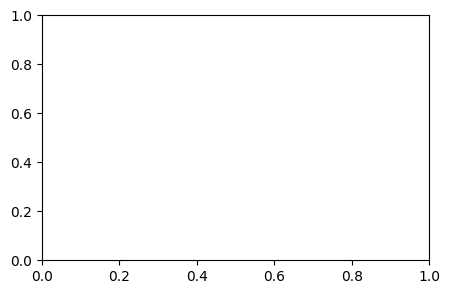

In [9]:
simulation.graph_show_scaled()

In [10]:
l = simulation.drone_list[0]
print(l.min_acc)
print(l.stop_distance)
# l.plot_history(time_step=time_step)

0.15
7.5


In [6]:
simulation.create_video()

### ここから下は動画を作るためのコード

・計算時間が結構長いのでそんなに頻繁に動かさない方が良いかも？

In [ ]:
import cv2
import os

images = []
frames = simulation.simulation_steps
drones = simulation.drone_list

for i in range(frames):
    if (i%4 ==1):
        continue
    plt.figure(figsize=(4,2.4))
    for (droneNum, drone) in enumerate(drones):
        if (droneNum == 0):
            plt.scatter(drone.xcorList[int(i)], 0, color="red", s=6)
        else:
            plt.scatter(drone.xcorList[int(i)], 0, color="grey", s=6)
    plt.xlim(drones[-1].xcorList[0], drones[0].xcorList[-1] )
    plt.savefig(f"tmp/frame_{i}.png")
    plt.close()

    filename = 'tmp/frame_{}.png'.format(i)
    img = cv2.imread(filename)
    images.append(img)
    os.remove(f"tmp/frame_{i}.png")
    if (i%100 == 0):
        print(f"frame_{i}__Done")

print("動画作成開始")
output_file = 'tmp/output.mp4'
fps = 60
size = (images[0].shape[1], images[0].shape[0])

# 動画を保存するためのオブジェクトを生成する
fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter(output_file, fourcc, fps, size)

# 100枚の画像を動画に書き込む
for i in range(len(images)):
    out.write(images[i])

# 動画を保存するための処理を終了する
out.release()
print("END")



In [9]:
drones = simulation.drone_list
print(drones[0].target_height)
print(drones[0].ycorList[660:760])
print(drones[0].xcorList[660:760])


7.5
[3.34149999999903, 3.2424999999990263, 3.1449999999990297, 3.048999999999026, 2.9544999999990296, 2.861499999999026, 2.7699999999990297, 2.6799999999990263, 2.59149999999903, 2.5044999999990267, 2.4189999999990306, 2.3349999999990274, 2.2524999999990314, 2.1714999999990283, 2.0919999999990324, 2.0139999999990295, 1.9374999999990334, 1.8624999999990308, 1.7889999999990351, 1.7169999999990324, 1.6464999999990368, 1.5774999999990342, 1.5099999999990388, 1.4439999999990363, 1.379499999999041, 1.3164999999990386, 1.2549999999990433, 1.194999999999041, 1.136499999999046, 1.0794999999990438, 1.0239999999990488, 0.9699999999990467, 0.9174999999990519, 0.8664999999990499, 0.8169999999990551, 0.7689995410027279, 0.7224971609654887, 0.6774913067735895, 0.6339803255721534, 0.5919624549679554, 0.5514358119199159, 0.5123983800921508, 0.47484799539695643, 0.43878232939535167, 0.40419887014752476, 0.371094900009993, 0.3394674697532736, 0.30931336821547006, 0.28062908649954466, 0.25341077544942436,

In [28]:
import cv2
import os

if simulation.boundary_condition != "FIXED":
    raise ValueError("この境界条件では使えません")

images = []
frames = simulation.simulation_steps
drones = simulation.drone_list


for i in range(frames):
    if (i%4 ==1):
        continue
    plt.figure(figsize=(5,3))
    for (droneNum, drone) in enumerate(drones):
        if (droneNum == 0):
            plt.scatter(drone.xcorList[int(i)], drone.ycorList[int(i)], color="red", s=6)
        else:
            plt.scatter(drone.xcorList[int(i)], drone.ycorList[int(i)], color="grey", s=6)
    plt.xlim(drones[-1].xcorList[0], TOTAL_DISTANCE )
    plt.ylim(0, drones[0].target_height*1.1 )
    plt.yticks(fontsize=8)
    plt.xticks(fontsize=8)
    plt.xlabel("Distance", fontsize=8)
    plt.ylabel("Height", fontsize=8)
    plt.savefig(f"tmp/frame_{i}.png")
    plt.close()

    filename = 'tmp/frame_{}.png'.format(i)
    img = cv2.imread(filename)
    images.append(img)
    os.remove(f"tmp/frame_{i}.png")
    if (i%100 == 0):
        print(f"frame_{i}__Done")

print("動画作成開始")
output_file = 'tmp/output_ycor.mp4'
fps = 60
size = (images[0].shape[1], images[0].shape[0])

# 動画を保存するためのオブジェクトを生成する
fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter(output_file, fourcc, fps, size)

# 100枚の画像を動画に書き込む
for i in range(len(images)):
    out.write(images[i])

# 動画を保存するための処理を終了する
out.release()
print("END")



frame_0__Done
frame_100__Done
frame_200__Done
frame_300__Done
frame_400__Done
frame_500__Done
frame_600__Done
frame_700__Done
frame_800__Done
frame_900__Done
動画作成開始


OpenCV: FFMPEG: tag 0x44495658/'XVID' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'


END


(array([-10.,   0.,  10.,  20.,  30.,  40.,  50.,  60.,  70.]),
 [Text(-10.0, 0, '−10'),
  Text(0.0, 0, '0'),
  Text(10.0, 0, '10'),
  Text(20.0, 0, '20'),
  Text(30.0, 0, '30'),
  Text(40.0, 0, '40'),
  Text(50.0, 0, '50'),
  Text(60.0, 0, '60'),
  Text(70.0, 0, '70')])

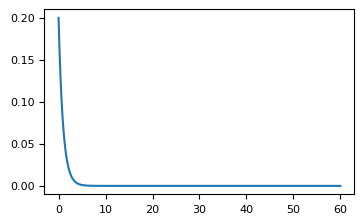

In [5]:
ax_list = np.diff(np.array(leader.v_xList))
t = np.linspace(0,time_step*(simulation_steps), simulation_steps)

plt.figure(figsize=(4,2.4))
plt.plot(t,ax_list)
plt.yticks(fontsize=8)
plt.xticks(fontsize=8)